In [1]:
from __future__ import print_function

import numpy as np
import operator
import matplotlib as mpl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
mpl.rcParams['font.size'] = 20.0
%matplotlib inline

BASE_PATH = "/home/dsavenk/"
LIVEQA_LOG_PATH = BASE_PATH + "data/liveqa/results_15/answers_log.txt"

QUESTION_SEPARATOR = "------------- QUESTION ----------------"
YA_QID_PREFIX = "https://answers.yahoo.com/question/index?qid="

In [2]:
def read_log(path):
    res = []
    with open(path, 'r') as log_input:
        for line in log_input:
            if line.startswith("FINE:"):
                res.append(line.strip("\n").replace("FINE: ", ""))
    return res

log = read_log(LIVEQA_LOG_PATH)

In [3]:
def parse_question_log(log, line_index):
    ya_data = []
    web_data = []
    question_qid = ""
    final_res = (ya_data, web_data)
    url2results = dict()
    scores = []
    line_index += 1
    while line_index < len(log) and log[line_index] != QUESTION_SEPARATOR:
        line = log[line_index]
        if line.startswith("QID:"):
            _, question_qid = line.split("\t")
        elif line.startswith("YA_QUERY_REFORMULATION"):
            if len(line.split("\t")) != 4:
                print(line_index, line, line.split("\t"))
            _, qid, reformulation_type, query = line.split("\t")
            ya_data.append({"type": reformulation_type, "query": query})
        elif line.startswith("YA_SIMILAR_QUESTIONS"):
            line = line.split("\t")
            query = line[1]
            results = line[2:]
            ya_data[-1]["results"] = filter(lambda res: res != question_qid, results)
            for res in results:
                if YA_QID_PREFIX + res not in url2results:
                    url2results[YA_QID_PREFIX + res] = []
                url2results[YA_QID_PREFIX + res].append(ya_data[-1])
        elif line.startswith("WEB_QUERY_REFORMULATION"):
            _, qid, reformulation_type, query = line.split("\t")
            web_data.append({"type": reformulation_type, "query": query})
        elif line.startswith("WEB_SEARCH_RESULTS"):
            line = line.split("\t")
            query = line[1]
            results = line[2:]
            web_data[-1]["results"] = results
            for res in results:
                if res not in url2results:
                    url2results[res] = []
                url2results[res].append(web_data[-1])
        elif line.startswith("SCORING"):
            _, url, fragment_type, score = line.split("\t")
            scores.append((float(score), url))

        line_index += 1

    scores.sort(key=operator.itemgetter(0), reverse=True)
    seen_url_scores = set([])
    for rank, score_url in enumerate(scores):
        score, url = score_url
        if url + str(score) in seen_url_scores:
            continue
        seen_url_scores.add(url + str(score))
        if url not in url2results:
            print("%s not in the dictionary!!!" % url)
        else:
            for res in url2results[url]:
                if "scores" not in res:
                    res["scores"] = []
                res["scores"].append(float(score))
                if "ranks" not in res:
                    res["ranks"] = []
                res["ranks"].append(rank)
        
    return line_index, final_res

index = 0
questions_data = []
while index < len(log):
    if log[index] == QUESTION_SEPARATOR:
        index, data = parse_question_log(log, index)
        questions_data.append(data)
    else:
        index += 1

Average number of candidates: Y!A:33.63	Web:67.50
Average score: Y!A:-15.18	Web:-20.50
Average rank: Y!A:46.36	Web:75.07
Average best rank: Y!A:5.22	Web:5.87
How often rank 1: Y!A:0.74	Web:0.54
How often no candidates: Y!A:0.14	Web:0.02


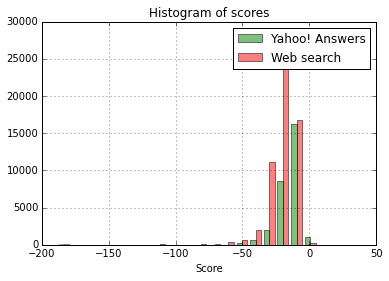

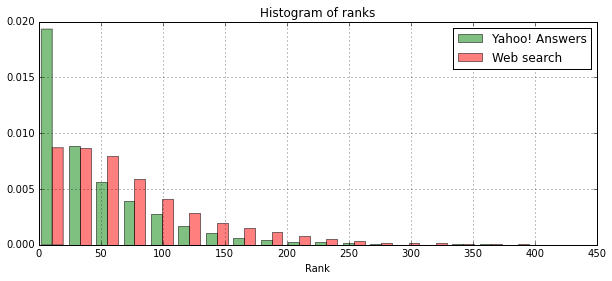

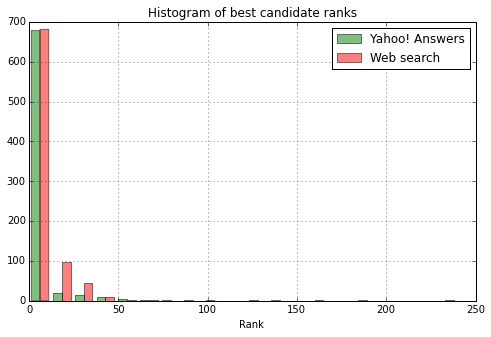

In [4]:
candidates_count = [0, 0]
scores = {"ya": [], "web": []}
ranks = {"ya": [], "web": []}
best_ranks = {"ya": [], "web": []}
no_candidates = {"ya": 0, "web": 0}
for data in questions_data:
    ya_data = data[0]
    web_data = data[1]
    ya_count = len([cand for rec in ya_data for cand in (rec["ranks"] if "ranks" in rec else [])])
    web_count = len([cand for rec in web_data for cand in (rec["ranks"] if "ranks" in rec else [])])
    scores["ya"].extend([score for rec in ya_data for score in (rec["scores"] if "scores" in rec else [])])
    scores["web"].extend([score for rec in web_data for score in (rec["scores"] if "scores" in rec else [])])
    cur_ya_ranks = [rank for rec in ya_data for rank in (rec["ranks"] if "ranks" in rec else [])]
    cur_web_ranks = [rank for rec in web_data for rank in (rec["ranks"] if "ranks" in rec else [])]
    ranks["ya"].extend(cur_ya_ranks)
    ranks["web"].extend(cur_web_ranks)
    if cur_ya_ranks:
        best_ranks["ya"].append(min(cur_ya_ranks))
    else:
        no_candidates["ya"] += 1
    if cur_web_ranks:
        best_ranks["web"].append(min(cur_web_ranks))
    else:
        no_candidates["web"] += 1
    candidates_count[0] += ya_count
    candidates_count[1] += web_count
print("Average number of candidates: Y!A:%.2f\tWeb:%.2f" % (1.0 * candidates_count[0] / len(questions_data), 1.0 * candidates_count[1] / len(questions_data)))
print("Average score: Y!A:%.2f\tWeb:%.2f" % (1.0 * sum(scores["ya"]) / len(scores["ya"]), 1.0 * sum(scores["web"]) / len(scores["web"])))
print("Average rank: Y!A:%.2f\tWeb:%.2f" % (1.0 * sum(ranks["ya"]) / len(ranks["ya"]), 1.0 * sum(ranks["web"]) / len(ranks["web"])))
print("Average best rank: Y!A:%.2f\tWeb:%.2f" % (1.0 * sum(best_ranks["ya"]) / len(best_ranks["ya"]), 1.0 * sum(best_ranks["web"]) / len(best_ranks["web"])))
print("How often rank 1: Y!A:%.2f\tWeb:%.2f" % (1.0 * sum(1 if rank == 0 else 0 for rank in best_ranks["ya"]) / len(best_ranks["ya"]), 1.0 * sum(1 if rank == 0 else 0 for rank in best_ranks["web"]) / len(best_ranks["web"])))
print("How often no candidates: Y!A:%.2f\tWeb:%.2f" % (1.0 * no_candidates["ya"] / len(questions_data), 1.0 * no_candidates["web"] / len(questions_data)))

plt.hist([scores["ya"], scores["web"]], bins=20, color=['green', "red"], alpha=0.5, label=["Yahoo! Answers", "Web search"])
plt.xlabel('Score')
plt.title('Histogram of scores')
plt.grid(True)
plt.grid(True)
plt.legend()

plt.figure(figsize=(10,4))
plt.hist([ranks["ya"], ranks["web"]], bins=20, color=['green', "red"], normed=True, alpha=0.5, label=["Yahoo! Answers", "Web search"])
plt.xlabel('Rank')
plt.title('Histogram of ranks')
plt.grid(True)
plt.legend()

plt.figure(figsize=(8,5))
plt.hist([best_ranks["ya"], best_ranks["web"]], bins=20, color=['green', "red"], alpha=0.5, label=["Yahoo! Answers", "Web search"])
plt.xlabel('Rank')
plt.title('Histogram of best candidate ranks')
plt.grid(True)
plt.legend()

plt.show()

# Statistics on Yahoo! Answers query formulations

# YA average number of candidates:
simple:1:0+category:	3.1330
tf-idf:title:	7.3256
simple:1:1:	2.5799
simple:1:0:	6.7561
simple:1:1+category:	0.8495
simple:0:0:	6.5741
simple:0:1:	2.4282
tf-idf:title+body:	3.9790


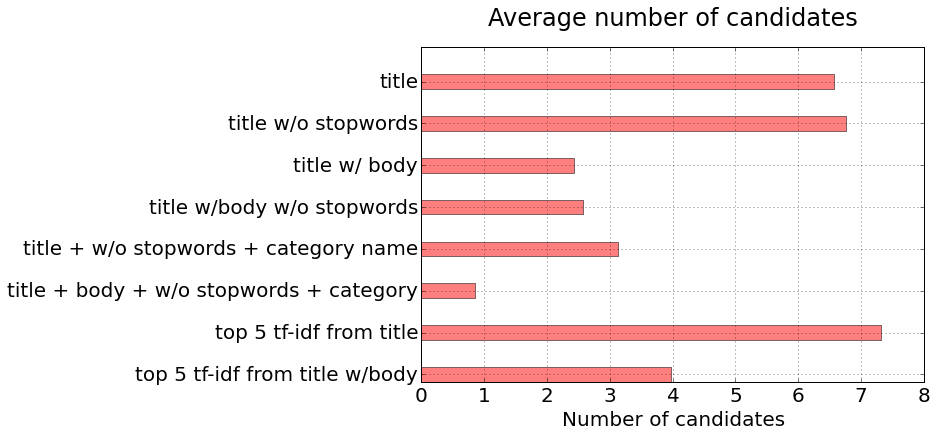


# YA average score of candidates:
simple:1:0+category:	-15.3140
tf-idf:title:	-14.9562
simple:1:1:	-16.5672
simple:1:0:	-13.4855
simple:1:1+category:	-19.7369
simple:0:0:	-13.4537
simple:0:1:	-16.4906
tf-idf:title+body:	-18.5137

# YA average rank of candidates:
simple:1:0+category:	73.28
tf-idf:title:	38.50
simple:1:1:	48.53
simple:1:0:	36.19
simple:1:1+category:	98.63
simple:0:0:	38.01
simple:0:1:	49.89
tf-idf:title+body:	55.99

# YA number of best candidates:
simple:1:0+category:	0.02
tf-idf:title:	0.49
simple:1:1:	0.25
simple:1:0:	0.45
simple:1:1+category:	0.01
simple:0:0:	0.42
simple:0:1:	0.23
tf-idf:title+body:	0.26


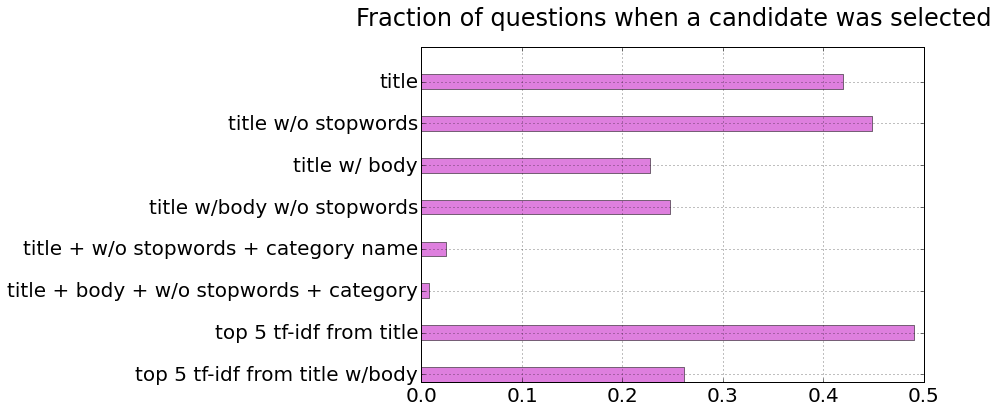


# YA best rank of candidates:
simple:1:0+category:	40.45
tf-idf:title:	7.37
simple:1:1:	13.69
simple:1:0:	8.15
simple:1:1+category:	46.31
simple:0:0:	7.82
simple:0:1:	11.78
tf-idf:title+body:	17.58


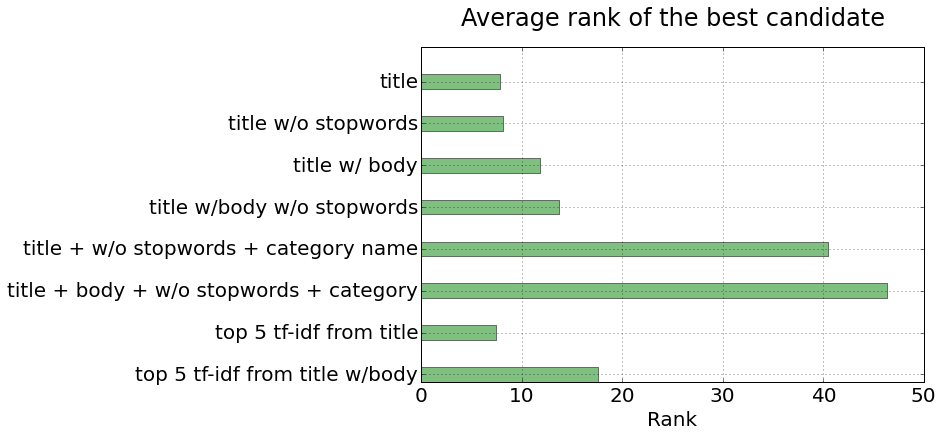


# YA no candidates:
simple:1:0+category:	0.5893
tf-idf:title:	0.1669
simple:1:1:	0.5648
simple:1:0:	0.2019
simple:1:1+category:	0.8810
simple:0:0:	0.2194
simple:0:1:	0.5869
tf-idf:title+body:	0.4352


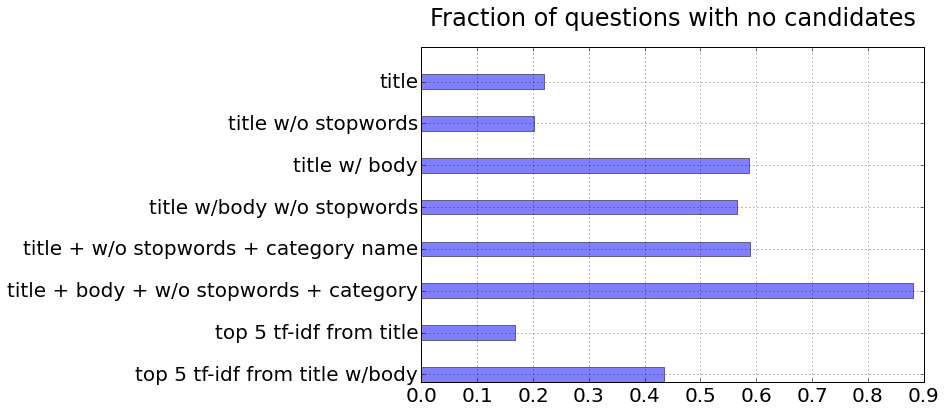

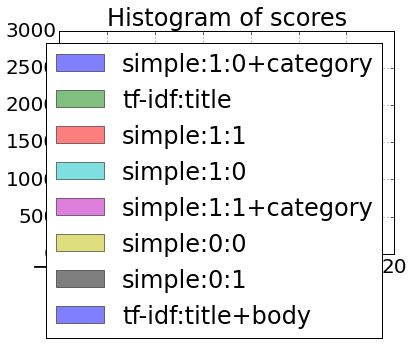

In [5]:
mpl.rcParams['font.size'] = 20.0

candidates_count = dict()
scores = dict()
ranks = dict()
best_ranks = dict()
no_candidates = dict()
for data in questions_data:
    seen_tfidf = False

    for rec in data[0]:
        tp = rec["type"]
        if tp == "tf-idf":
            if not seen_tfidf:
                seen_tfidf = True
                tp = "tf-idf:title+body"
            else:
                tp = "tf-idf:title"
            
        if tp not in candidates_count:
            candidates_count[tp] = 0
            scores[tp] = []
            ranks[tp] = []
            best_ranks[tp] = []
            no_candidates[tp] = 0
        candidates_count[tp] += len([cand for cand in (rec["ranks"] if "ranks" in rec else [])])
                
        scores[tp].extend([score for score in (rec["scores"] if "scores" in rec else [])])
        cur_ranks = [rank for rank in (rec["ranks"] if "ranks" in rec else [])]
        ranks[tp].extend(cur_ranks)
        if cur_ranks:
            best_ranks[tp].append(min(cur_ranks))
        else:
            no_candidates[tp] += 1
            
print("# YA average number of candidates:")
for tp, value in candidates_count.iteritems():
    print(tp + ":\t%.4f" % (1.0 * value / len(questions_data)))

names = ["simple:0:0", "simple:1:0", "simple:0:1", "simple:1:1", "simple:1:0+category", "simple:1:1+category", "tf-idf:title", "tf-idf:title+body"]
full_names = ["title", "title w/o stopwords", "title w/ body", "title w/body w/o stopwords", "title + w/o stopwords + category name", "title + body + w/o stopwords + category", "top 5 tf-idf from title", "top 5 tf-idf from title w/body"]
vals = [1.0 * candidates_count[name] / len(questions_data) for name in names]
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots(figsize=(9,6))
average_bars = ax.barh(ind, vals[::-1], width, color='r', alpha=0.5)
# add some text for labels, title and axes ticks
ax.set_xlabel('Number of candidates')
plt.yticks(ind + width/2, full_names[::-1], rotation=0, fontsize=20)
plt.grid(True)
plt.title("Average number of candidates", y=1.05)
plt.show()
    
    
print("\n# YA average score of candidates:")
for tp, cur_scores in scores.iteritems():
    print(tp + ":\t%.4f" % (1.0 * sum(cur_scores) / len(cur_scores)))
    
print("\n# YA average rank of candidates:")
for tp, cur_ranks in ranks.iteritems():
    print(tp + ":\t%.2f" % (1.0 * sum(cur_ranks) / len(cur_ranks)))
    
print("\n# YA number of best candidates:")
for tp, cur_ranks in ranks.iteritems():
    print(tp + ":\t%.2f" % (1.0 * cur_ranks.count(0) / len(questions_data)))
vals = [(1.0 * ranks[name].count(0) / len(questions_data)) for name in names]
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots(figsize=(9,6))
average_bars = ax.barh(ind, vals[::-1], width, color='m', alpha=0.5)
# add some text for labels, title and axes ticks
# ax.set_xlabel()
plt.yticks(ind + width/2, full_names[::-1], rotation=0, fontsize=20)
plt.grid(True)
plt.title('Fraction of questions when a candidate was selected', y=1.05)
plt.show()
    

print("\n# YA best rank of candidates:")
for tp, cur_best_ranks in best_ranks.iteritems():
    print(tp + ":\t%.2f" % (1.0 * sum(cur_best_ranks) / len(cur_best_ranks)))
vals = [1.0 * sum(best_ranks[name]) / len(best_ranks[name]) for name in names]
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots(figsize=(9,6))
average_bars = ax.barh(ind, vals[::-1], width, color='g', alpha=0.5)
# add some text for labels, title and axes ticks
ax.set_xlabel('Rank')
plt.yticks(ind + width/2, full_names[::-1], rotation=0, fontsize=20)
plt.grid(True)
plt.title("Average rank of the best candidate", y=1.05)
plt.show()
    
print("\n# YA no candidates:")
for tp, cur_no_candidates in no_candidates.iteritems():
    print(tp + ":\t%.4f" % (1.0 * cur_no_candidates / len(questions_data)))
vals = [1.0 * no_candidates[name] / len(questions_data) for name in names]
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots(figsize=(9,6))
average_bars = ax.barh(ind, vals[::-1], width, color='b', alpha=0.5)
# add some text for labels, title and axes ticks
plt.title('Fraction of questions with no candidates', y=1.05)
plt.yticks(ind + width/2, full_names[::-1], rotation=0, fontsize=20)
plt.grid(True)
plt.show()
    
# the histogram of the data
plt.hist(scores.values(), bins=20, alpha=0.5, label=scores.keys())
plt.xlabel('Score')
plt.title('Histogram of scores')
plt.grid(True)
plt.grid(True)
plt.legend()
plt.show()

# Statistics on Web query formulation

# Web average number of candidates:
simple:0:0:	36.8938
simple:0:1:	30.6079


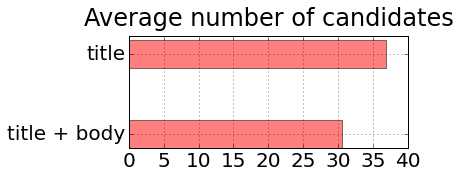


# Web average score of candidates:
simple:0:0:	-19.7780
simple:0:1:	-21.3729

# Web average rank of candidates:
simple:0:0:	64.0000
simple:0:1:	87.0000

# Web best rank of candidates:
simple:0:0:	6.0000
simple:0:1:	20.0000


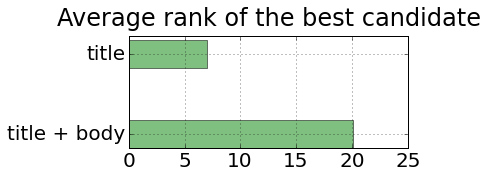


# Web no candidates:
simple:0:0:	0.0012
simple:0:1:	0.1587


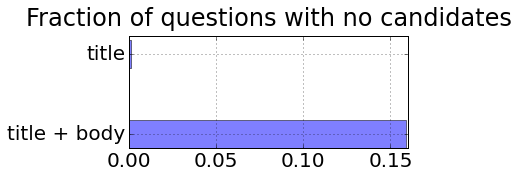

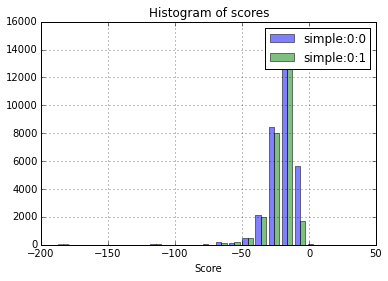

In [6]:
candidates_count = dict()
scores = dict()
ranks = dict()
best_ranks = dict()
no_candidates = dict()
for data in questions_data:
    seen_tfidf = False
    for rec in data[1]:
        tp = rec["type"]
        if tp == "tf-idf":
            if not seen_tfidf:
                seen_tfidf = True
                tp = "tf-idf:title"
            else:
                tp = "tf-idf:title+body"
            
        if tp not in candidates_count:
            candidates_count[tp] = 0
            scores[tp] = []
            ranks[tp] = []
            best_ranks[tp] = []
            no_candidates[tp] = 0
        candidates_count[tp] += len([cand for cand in (rec["ranks"] if "ranks" in rec else [])])
        scores[tp].extend([score for score in (rec["scores"] if "scores" in rec else [])])
        cur_ranks = [rank for rank in (rec["ranks"] if "ranks" in rec else [])]
        ranks[tp].extend(cur_ranks)
        if cur_ranks:
            best_ranks[tp].append(min(cur_ranks))
        else:
            no_candidates[tp] += 1

names = ["simple:0:0", "simple:0:1"]
full_names = ["title", "title + body"]
print("# Web average number of candidates:")
for tp, value in candidates_count.iteritems():
    print(tp + ":\t%.4f" % (1.0 * value / len(questions_data)))
vals = [1.0 * candidates_count[name] / len(questions_data) for name in names]
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots(figsize=(5,2))
average_bars = ax.barh(ind, vals[::-1], width, color='r', alpha=0.5)
# add some text for labels, title and axes ticks
# ax.set_xlabel('Number of candidates')
plt.yticks(ind + width/2, full_names[::-1], rotation=0, fontsize=20)
plt.grid(True)
plt.title("Average number of candidates", y=1.05)
plt.show()

print("\n# Web average score of candidates:")
for tp, cur_scores in scores.iteritems():
    print(tp + ":\t%.4f" % (sum(cur_scores) / len(cur_scores)))
    
print("\n# Web average rank of candidates:")
for tp, cur_ranks in ranks.iteritems():
    print(tp + ":\t%.4f" % (sum(cur_ranks) / len(cur_ranks)))
    
print("\n# Web best rank of candidates:")
for tp, cur_best_ranks in best_ranks.iteritems():
    print(tp + ":\t%.4f" % (sum(cur_best_ranks) / len(cur_best_ranks)))
vals = [1.0 * sum(best_ranks[name]) / len(best_ranks[name]) for name in names]
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots(figsize=(5,2))
average_bars = ax.barh(ind, vals[::-1], width, color='g', alpha=0.5)
# add some text for labels, title and axes ticks
# ax.set_xlabel('Rank')
plt.yticks(ind + width/2, full_names[::-1], rotation=0, fontsize=20)
plt.grid(True)
plt.title("Average rank of the best candidate", y=1.05)
plt.show()
    
print("\n# Web no candidates:")
for tp, cur_no_candidates in no_candidates.iteritems():
    print(tp + ":\t%.4f" % (1.0 * cur_no_candidates / len(questions_data)))
    vals = [1.0 * no_candidates[name] / len(questions_data) for name in names]
ind = np.arange(len(names))  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots(figsize=(5,2))
average_bars = ax.barh(ind, vals[::-1], width, color='b', alpha=0.5)
# add some text for labels, title and axes ticks
plt.title('Fraction of questions with no candidates', y=1.05)
plt.xticks(np.arange(0,0.2,0.05), fontsize=20)
plt.yticks(ind + width/2, full_names[::-1], rotation=0, fontsize=20)
plt.grid(True)
plt.show()
    
# the histogram of the data
%matplotlib inline
plt.hist(scores.values(), bins=20, alpha=0.5, label=scores.keys())
plt.xlabel('Score')
plt.title('Histogram of scores')
plt.grid(True)
plt.grid(True)
plt.legend()
plt.show()